A.S. Lundervold, v.100124

# Introduction

In this notebook, we explore another basic example of image classification. We will use a dataset called PlantDoc, which contains images of 38 different plant species. The dataset is described in the paper [PlantDoc: A Dataset for Visual Plant Disease Detection](https://arxiv.org/pdf/1911.10317.pdf) by Davinder Singh et al. (2019). It's available via GitHub: https://github.com/pratikkayal/PlantDoc-Dataset. 

<img src="assets/plantdoc.png">

# Setup

**These first cells are included to make sure we can run the notebook locally and on both Google Colab and Kaggle:**

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

Define where to store the data: 

In [3]:
from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/')

else:
    # Change this to the directory where you want to store the data.
    DATA = Path.home()/'data'/'dat255'
    DATA.mkdir(exist_ok=True, parents=True)

**Checking for GPU/MPS availability:**

If you're running on a Mac with Metal Performance Shaders (M-series), some features of PyTorch aren't supported. Therefore, we add a fallback:

In [4]:
import os
import torch

if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

Then we check for GPU/MPS:

In [5]:
import fastai.torch_core

device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')

In [6]:
print(device)

cuda:0


> **Explanation:** The above code checks for the availability of a GPU or MPS (Metal Performance Shaders, used in Apple's M1/M2 chips) to accelerate model training. If neither is available, it defaults to using the CPU. Using GPU or MPS significantly speeds up deep learning tasks.

## Import packages

In [7]:
from fastai.vision.all import *

# Load data

We'll use the [PlantDoc data set](https://github.com/pratikkayal/PlantDoc-Dataset). It is available from GitHub:

In [8]:
url = "https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip"


In [9]:
%%capture
path = untar_data(url, archive=DATA, data=DATA)

In [10]:
path.ls()

(#4) [Path('/home/alex/data/dat255/master/train'),Path('/home/alex/data/dat255/master/README.md'),Path('/home/alex/data/dat255/master/LICENSE.txt'),Path('/home/alex/data/dat255/master/test')]

# Inspect the data

In [11]:
get_image_files(path)

(#2576) [Path('/home/alex/data/dat255/master/train/Soyabean leaf/kdeficiency4.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/asoybeanleafcloseup.JPG.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/stock-photo-soybean-on-the-pod-with-leaves-for-healthy-eating-concept-62173117.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/6.15.12+Soybeans+V3.JPG.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/soybean-leaf-single.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/stock-photo-green-soy-pods-with-leaves-isolated-on-white-backgraund-310996559.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/soybean-21357451.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/Leaves-of-Soybean.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/double-crop-soybean-leaves-Aug-19-2013_thumb.jpg'),Path('/home/alex/data/dat255/master/train/Soyabean leaf/Soybean%20tofu%20leaf.JPG.jpg')...]

In [12]:
# For convenience, we delete the file `PlantDoc_Examples.png`: 
try: 
    (path/'PlantDoc_Examples.png').unlink()
except:
    print("File already deleted")

File already deleted


## What is the label distribution?

In [13]:
train_path = path/'train'
test_path = path/'test'

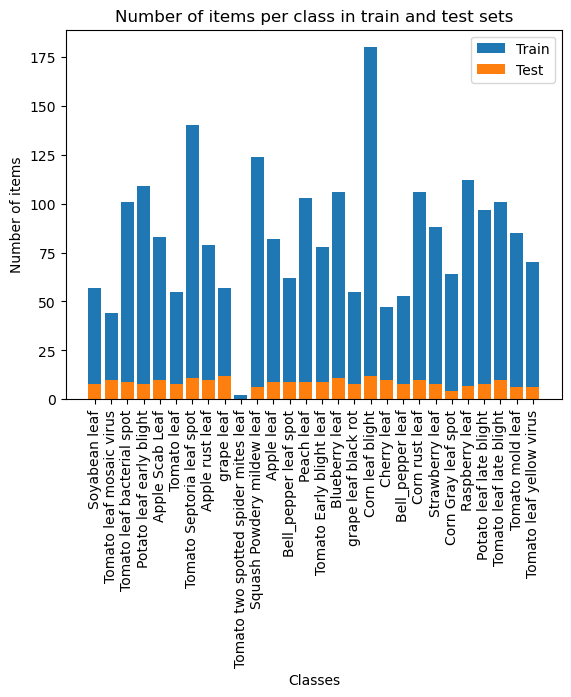

In [41]:
# Create dictionaries for train and test classes with the class name as the key and the number of items as the value
train_classes = {p.stem: len(list(p.iterdir())) for p in train_path.iterdir()}
test_classes = {p.stem: len(list(p.iterdir())) for p in test_path.iterdir()}

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Add bars for train and test classes with appropriate labels
ax.bar(train_classes.keys(), train_classes.values(), label='Train')
ax.bar(test_classes.keys(), test_classes.values(), label='Test')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Number of items')
ax.set_title('Number of items per class in train and test sets')

# Add a legend
ax.legend()

# Display the plot
plt.show()

# Dataloaders and data augmentation

## Create dataloaders

In [ ]:
def get_dataloaders(path, item_sz=128, bs=64, batch_tfms=None):
    """
    Function to get dataloaders from a given path.

    Parameters:
    path (str): The path to the data directory.
    item_sz (int): The size of the items. Default is 128.
    bs (int): Batch size. Default is 64.
    batch_tfms (list): List of batch transformations. Default is None.

    Returns:
    dls: Dataloaders for the given path.
    """
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter(
            train_name='train', 
            valid_name='test'
        ),
        get_y=parent_label,
        item_tfms=Resize(item_sz),
        batch_tfms=batch_tfms
    )
    
    dls = dblock.dataloaders(path, bs=bs)
    return dls

In [17]:
# Lower the batch size if you run out of memory.
bs=64
dls=get_dataloaders(path,bs=bs)

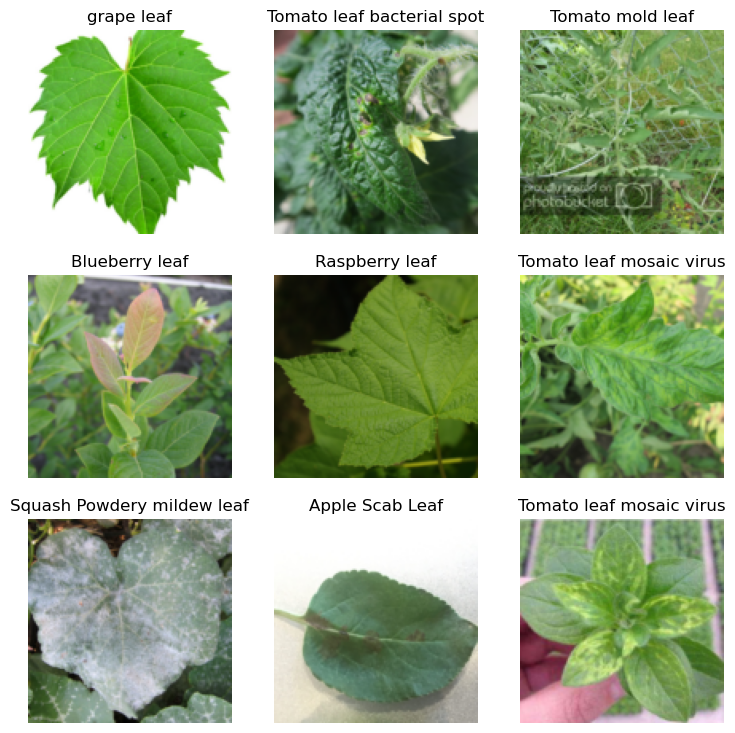

In [18]:
dls.show_batch()

## Data augmentation

Data augmentation in image classification serves as a pivotal technique to effectively expand the dataset used for training without the need to collect more images. This approach increases the volume of training data and introduces a level of robustness in the model, making it more adept at handling varied real-world scenarios. The underlying principle of data augmentation is to create modified versions of the existing images in ways likely to be encountered in real-life applications while ensuring that the fundamental category or label of the image remains unaltered.

A critical aspect of data augmentation is that the transformations must not change the inherent content or meaning of the image in a way that would require a different label. For instance, flipping an image of a cat horizontally still represents the same category as 'cat,' but excessively distorting the image to a point where it's no longer recognizable would be counterproductive.

There is a broad spectrum of data augmentation techniques, ranging from simple to advanced. Simple techniques include rotation (where you turn the images at various angles) and flipping (horizontally or vertically). These transformations mimic the variations often seen in real-world scenarios, where objects can appear in different orientations.

> See the fastai docs at https://docs.fast.ai/vision.augment.html for some examples and Chapter 2 of the fastai book for more about data augmentation. 

This Jupyter Notebook will use several basic data augmentation techniques, including adjusting contrast, rotation, brightness, and saturation. These methods are straightforward yet effective in diversifying the training data. For instance, altering brightness and contrast simulates different lighting conditions, while rotation and saturation adjustments cover a range of perspectives and color variations. Additionally, zooming in on images can help the model focus on different parts of the objects, and random erasing of pixels introduces an element of occlusion, training the model to recognize objects even when parts of them are obscured or missing. 

**We'll learn about more advanced data augmentation techniques later in the course.**

### Basic data augmentation

In [19]:
# Reduce the image sizes if you run out of GPU memory
item_sz=500
batch_sz=400

In [ ]:
# Define batch transformations
batch_tfms = [
    Resize(batch_sz), 
    Contrast(), 
    Dihedral(), 
    Brightness(), 
    Rotate(max_deg=45), 
    Saturation(), 
    Warp(), 
    Zoom(),
    RandomErasing(sh=0.1, max_count=3), 
    Normalize.from_stats(*imagenet_stats)
]

In [27]:
dls = get_dataloaders(item_sz=item_sz, bs=bs, batch_tfms=batch_tfms)

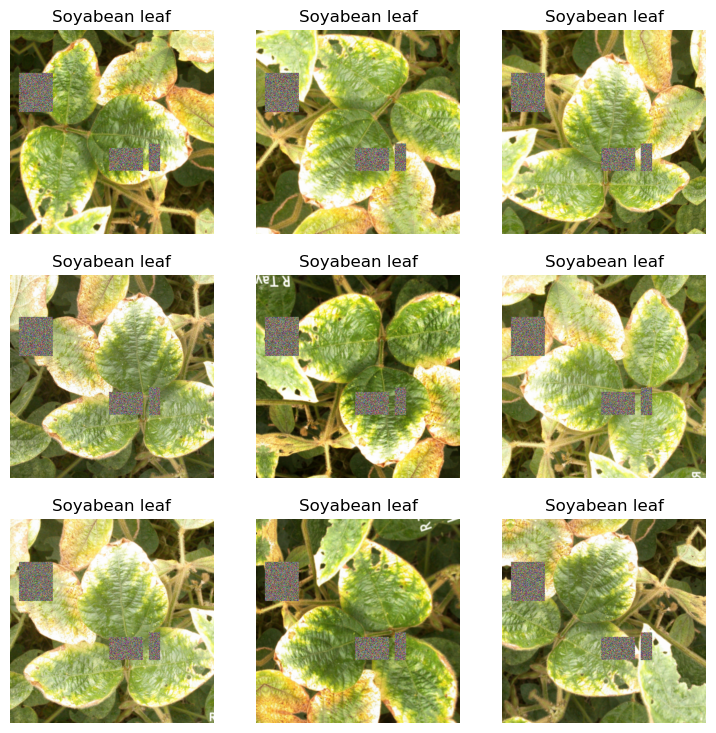

In [28]:
# Check the effect of data augmentation
dls.show_batch(unique=True)

# Train a model

In [29]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

In [32]:
#doc(learn.lr_find)

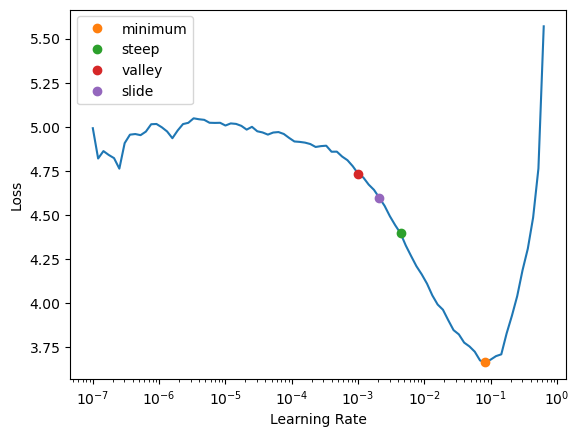

In [33]:
lr_sugg = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [34]:
learn.fine_tune(6, lr_sugg.slide)

epoch,train_loss,valid_loss,accuracy,time
0,3.583597,1.939776,0.398305,00:20


epoch,train_loss,valid_loss,accuracy,time
0,2.095199,1.613098,0.491525,00:24
1,1.720697,1.350866,0.597458,00:23
2,1.429797,1.290400,0.618644,00:24
3,1.194996,1.234075,0.631356,00:23
4,1.020453,1.224540,0.639831,00:23
5,0.880946,1.199071,0.644068,00:24


> This can be compared with the dataset creators results from 2020: https://arxiv.org/pdf/1911.10317.pdf. They report 70.53% accuracy on the test set using an InceptionResNetV2 model pretrained on another plant dataset (https://www.frontiersin.org/articles/10.3389/fpls.2016.01419/full). Using only ImageNet pretraining (as we did above), they report an accuracy of 49.04% using their top performing model (InceptionResNetV2).

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused()

[('Corn leaf blight', 'Corn Gray leaf spot', 4),
 ('Tomato leaf bacterial spot', 'Tomato Septoria leaf spot', 4),
 ('Bell_pepper leaf spot', 'Tomato leaf bacterial spot', 3),
 ('Cherry leaf', 'Apple leaf', 3),
 ('Tomato leaf mosaic virus', 'Tomato mold leaf', 3),
 ('Apple rust leaf', 'Apple Scab Leaf', 2),
 ('Bell_pepper leaf', 'Bell_pepper leaf spot', 2),
 ('Blueberry leaf', 'Apple leaf', 2),
 ('Cherry leaf', 'Blueberry leaf', 2),
 ('Corn Gray leaf spot', 'Corn leaf blight', 2),
 ('Peach leaf', 'Apple leaf', 2),
 ('Potato leaf early blight', 'Potato leaf late blight', 2),
 ('Potato leaf late blight', 'Potato leaf early blight', 2),
 ('Potato leaf late blight', 'Tomato leaf late blight', 2),
 ('Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 2),
 ('Tomato leaf bacterial spot', 'Bell_pepper leaf spot', 2),
 ('Tomato leaf bacterial spot', 'Tomato Early blight leaf', 2),
 ('Tomato leaf late blight', 'Potato leaf early blight', 2),
 ('Tomato leaf late blight', 'Potato leaf late b

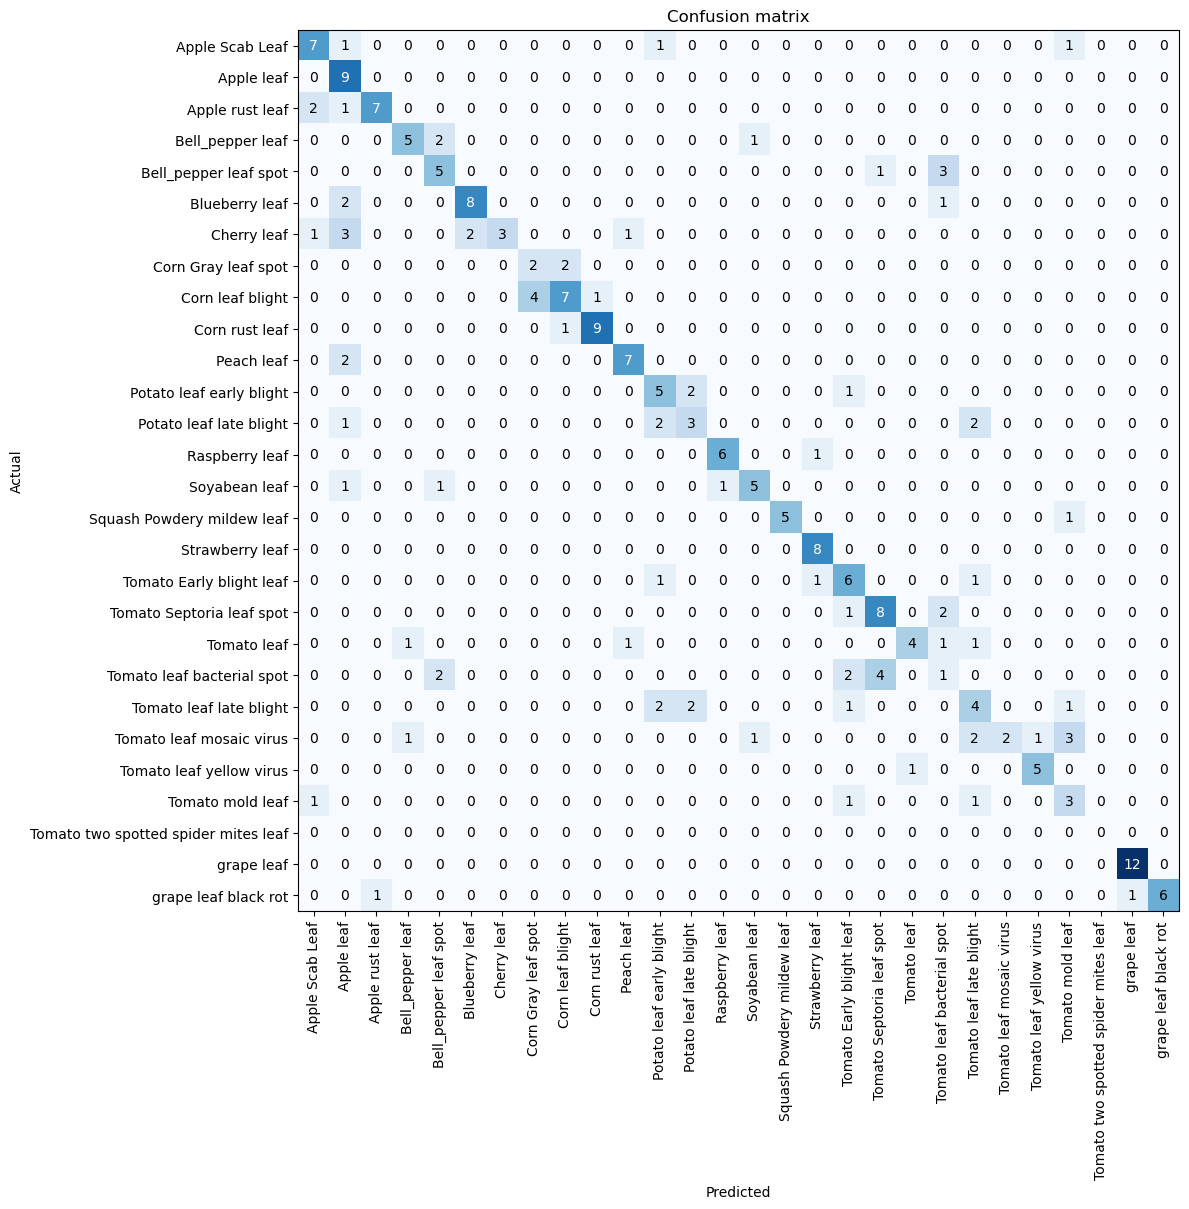

In [36]:
interp.plot_confusion_matrix(figsize=(12,12))

## Extra: Try other models

In [27]:
# Free up memory:
import gc
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [28]:
# Install the latest version of timm
#%pip install git+https://github.com/rwightman/pytorch-image-models.git
%pip install timm

Note: you may need to restart the kernel to use updated packages.


In [29]:
import timm

In [30]:
timm.list_models('resnex*', pretrained=True)

['resnext26ts.ra2_in1k',
 'resnext50_32x4d.a1_in1k',
 'resnext50_32x4d.a1h_in1k',
 'resnext50_32x4d.a2_in1k',
 'resnext50_32x4d.a3_in1k',
 'resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k',
 'resnext50_32x4d.fb_swsl_ig1b_ft_in1k',
 'resnext50_32x4d.gluon_in1k',
 'resnext50_32x4d.ra_in1k',
 'resnext50_32x4d.tv2_in1k',
 'resnext50_32x4d.tv_in1k',
 'resnext50d_32x4d.bt_in1k',
 'resnext101_32x4d.fb_ssl_yfcc100m_ft_in1k',
 'resnext101_32x4d.fb_swsl_ig1b_ft_in1k',
 'resnext101_32x4d.gluon_in1k',
 'resnext101_32x8d.fb_ssl_yfcc100m_ft_in1k',
 'resnext101_32x8d.fb_swsl_ig1b_ft_in1k',
 'resnext101_32x8d.fb_wsl_ig1b_ft_in1k',
 'resnext101_32x8d.tv2_in1k',
 'resnext101_32x8d.tv_in1k',
 'resnext101_32x16d.fb_ssl_yfcc100m_ft_in1k',
 'resnext101_32x16d.fb_swsl_ig1b_ft_in1k',
 'resnext101_32x16d.fb_wsl_ig1b_ft_in1k',
 'resnext101_32x32d.fb_wsl_ig1b_ft_in1k',
 'resnext101_64x4d.c1_in1k',
 'resnext101_64x4d.gluon_in1k',
 'resnext101_64x4d.tv_in1k']

In [31]:
timm.list_models('convnext*', pretrained=True)

['convnext_atto.d2_in1k',
 'convnext_atto_ols.a2_in1k',
 'convnext_base.clip_laion2b',
 'convnext_base.clip_laion2b_augreg',
 'convnext_base.clip_laion2b_augreg_ft_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k_384',
 'convnext_base.clip_laiona',
 'convnext_base.clip_laiona_320',
 'convnext_base.clip_laiona_augreg_320',
 'convnext_base.clip_laiona_augreg_ft_in1k_384',
 'convnext_base.fb_in1k',
 'convnext_base.fb_in22k',
 'convnext_base.fb_in22k_ft_in1k',
 'convnext_base.fb_in22k_ft_in1k_384',
 'convnext_femto.d1_in1k',
 'convnext_femto_ols.d1_in1k',
 'convnext_large.fb_in1k',
 'convnext_large.fb_in22k',
 'convnext_large.fb_in22k_ft_in1k',
 'convnext_large.fb_in22k_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',

In [32]:
model = 'convnext_small.fb_in22k'
#model = 'resnext50_32x4d.a3_in1k'

These models consume a lot of GPU memory, so we'll use a smaller batch size:

In [33]:
bs = 32
dls = get_dataloaders(path, item_sz=item_sz, bs=bs, batch_tfms=batch_tfms)

In [34]:
learn = vision_learner(dls, model, pretrained=True, metrics=accuracy)

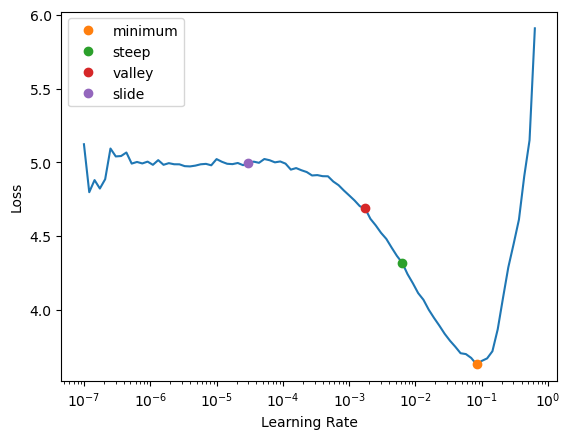

In [35]:
lr_sugg = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [36]:
learn.fine_tune(6, base_lr=(lr_sugg.slide + lr_sugg.valley)/2)

epoch,train_loss,valid_loss,accuracy,time
0,3.258560,1.625970,0.538136,01:01


epoch,train_loss,valid_loss,accuracy,time
0,1.775965,1.262112,0.576271,02:07
1,1.486421,1.012406,0.635593,02:06
2,1.161950,0.996022,0.686441,02:06
3,0.995169,0.862526,0.733051,02:06
4,0.845465,0.858908,0.703390,02:05
5,0.775211,0.843388,0.720339,02:05


> This can again be compared with the dataset creators results from 2020: https://arxiv.org/pdf/1911.10317.pdf. They report 70.53% accuracy on the test set using an InceptionResNetV2 model pretrained on another plant dataset. Using only ImageNet pretraining (as we did above), they report an accuracy of 49.04% using their top performing model (InceptionResNetV2).

# What's next?

> We'll learn many more tricks and techniques for improving our models later in the course. You may want to revisit this notebook later and try to improve the results.